# Demo 2: MLFlow with Nested Runs. XGBoost Hyperparameter Tuning with HyperOpt using MLFlow

**Authored by:** Joshua Isanan

**Date:** 07/28/2024

Let's rerun the same code blocks from Demo 1 for loading the MLClient, as well as the dataset.

In [1]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import numpy as np

resource_group = "RESOURCE GROUP"
subscription_id = "SUBSCRIPTION ID"
workspace = "WORKSPACE NAME"

ml_client = MLClient(
    DefaultAzureCredential(), subscription_id, resource_group, workspace
)

In [3]:
dataset =  ml_client.data.get(name="purchase-prediction-dataset", version="1")

In [4]:
import pandas as pd
import numpy as np

dataset = pd.read_csv(dataset.path)

In [5]:
m = dataset.select_dtypes(np.number)
dataset[m.columns]= m.astype('float')
dataset["PurchaseStatus"]= dataset["PurchaseStatus"].astype('float')

This time we'll create a new experiment, logging our XGBoost hyperopt results to "purchase-prediction-hyperopt-tuning".

In [6]:
import mlflow

mlflow.set_experiment(experiment_name="purchase-prediction-hyperopt-tuning")

<Experiment: artifact_location='', creation_time=1721723893476, experiment_id='52e3d2d4-5762-4d3e-8833-fa3fb7a1af6c', last_update_time=None, lifecycle_stage='active', name='purchase-prediction-hyperopt-tuning', tags={}>

In [7]:
%pip install xgboost
%pip install matplotlib
%pip install shap
%pip install hyperopt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Ensure that your random_state is the same in all Demos, this ensures that your model training and evaluation will utilize the same train-test split.

In [8]:
from mlflow.models import infer_signature
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("PurchaseStatus", axis=1), dataset["PurchaseStatus"], test_size=0.3, random_state=5)

signature = infer_signature(X_test, y_test)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier

# Create a pipeline with ColumnTransformer to drop columns
# preprocessor = ColumnTransformer(
#     transformers=[
#             ('column_dropper', 'drop', ["Gender"]),
#                 ]
# )

preprocessor = ColumnTransformer(
    [
        ('column_dropper', 'drop', ["Gender"]),
        (
        "cat_encoding",
        OrdinalEncoder(
            categories="auto",
            encoded_missing_value=np.nan,
        ),
        ["ProductCategory"],
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# model = XGBClassifier(use_label_encoder=False, eval_metric="auc")

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor)
    ]
)

For Hyperopt, we would need to create our search space for all our hyperparameters.
 
More on this: http://hyperopt.github.io/hyperopt/getting-started/search_spaces/

In [10]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
      }

We'll then create our objective function, this will be the evaluation criteria for our child runs in searching for the optimal hyperparameters. 

We try to minimize the loss parameter, which in this case, is the negative F1 Score.

For MLFlow, we must ensure that our start_run method specifically states that it is a nested(child) run.

In [11]:
from sklearn.metrics import f1_score
from typing import Any, Dict
import warnings
warnings.filterwarnings('ignore')

def objective(space: Dict[str, Any], pipeline:None):
    with mlflow.start_run(nested=True, run_name="hyperopt" + "_".join(space.keys())) as child_run:
        mlflow.xgboost.autolog(silent=True)
        mlflow.sklearn.autolog(silent=True)

        clf=XGBClassifier(eval_metric="auc",
                        n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']))
        
        eval_set = [(pipeline.fit_transform(X_test), y_test)]
        pipeline.steps.append(['model', clf])

        pipeline.fit(X_train, y_train,
                model__eval_set=eval_set,
                model__verbose=False)

        pred = pipeline.predict(X_test)
        f1_result = f1_score(y_test, pred)
        mlflow.log_metric("f1_score", f1_result)
        mlflow.log_param("hyperparameters", space)
        pipeline.steps.pop(1)
        return {'loss': -f1_result, 'status': STATUS_OK, "attachments": {"run_id": child_run.info.run_id}}

We then create the main run in our experiment, which calls the objective function to search for the optimal hyperparameters for our new model.

We can also explicitly log params and metrics in our experiments.

Working in MLflow run: d2beab02-cee3-44a0-8e7e-33b02c2e953e
 41%|████      | 41/100 [04:17<06:11,  6.29s/trial, best loss: -0.9552238805970149]
Showing Histogram of 41 jobs


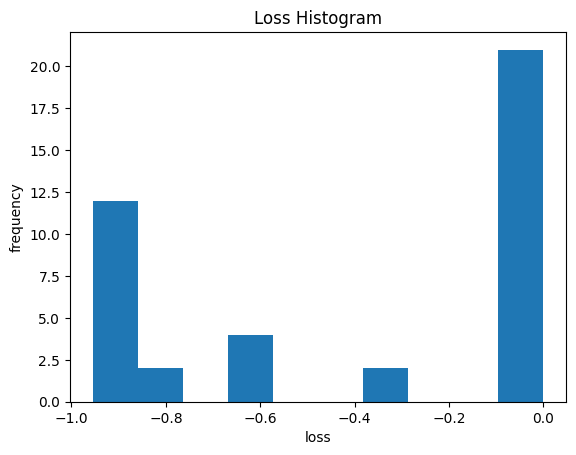

In [12]:
from hyperopt.early_stop import no_progress_loss
from functools import partial

import hyperopt.plotting
import matplotlib.pyplot as plt

with mlflow.start_run(run_name="hyperopt_tuning") as tuning_run:
    print("Working in MLflow run:", tuning_run.info.run_id)
    trials = Trials()
    best_params = fmin(
        fn=partial(objective, pipeline = pipeline),
        space=space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials,
        early_stop_fn=no_progress_loss(30)
    )

    
    best_run_id = trials.trial_attachments(trials.best_trial)["run_id"]

    client = mlflow.tracking.MlflowClient()

    mlflow.log_param("best_run_id", best_run_id)
    mlflow.log_params({f"best_{p}": v for p, v in best_params.items()})
    mlflow.log_metric("best_f1_score", -trials.best_trial["result"]["loss"])

    clf=XGBClassifier(
        eval_metric="auc",
        max_depth = int(best_params['max_depth']),
        gamma = best_params['gamma'],
        reg_alpha = int(best_params['reg_alpha']),
        min_child_weight=int(best_params['min_child_weight']),
        colsample_bytree=int(best_params['colsample_bytree']),
        n_estimators=180,
        seed=0
    )

    eval_set = [(pipeline.fit_transform(X_test), y_test)]
    pipeline.steps.append(['model', clf])

    pipeline.fit(X_train, y_train,
        model__eval_set=eval_set,
        model__verbose=False)

    best_model = mlflow.sklearn.log_model(pipeline, artifact_path="pipeline", signature=signature)

    fig = plt.figure()
    ax = fig.add_subplot()
    hyperopt.plotting.main_plot_histogram(trials, do_show=False)
    mlflow.log_figure(fig, "loss_histogram.png")


Let's take a look at the best hyperparameters chosen.

In [13]:
best_params

{'colsample_bytree': 0.6615705810574923,
 'gamma': 8.55784391067195,
 'max_depth': 6.0,
 'min_child_weight': 7.0,
 'reg_alpha': 1.0,
 'reg_lambda': 0.7548562425394715}

Let's take our initial model, and see if this new Hyperopt Hyperparameter tuned XGBoost model shows an improvement over our initial model.

In [14]:
baseline_model = ml_client.models.get(name="initial_model", version="5")

Let's create the criteria for our new model before we can say that this can replace our initial model. 
We must ensure that the F1 Score is at least above .8, and the new model is at least .03 better than our previous model.

If that criteria is met, our experiment will turn out successful and we can register this model as our new baseline model.

In [15]:
from mlflow.models import MetricThreshold

# Define criteria for model to be validated against
thresholds = {
    "f1_score": MetricThreshold(
        threshold=0.8,  # f1score should be >=0.8
        min_absolute_change=0.03,  # f1score should be at least 0.03 greater than baseline model f1score
        min_relative_change=0.03,  # f1score should be at least 3 percent greater than baseline model f1score
        greater_is_better=True,
    ),
}

with mlflow.start_run(run_name="Initial Model vs. Hyperopt Model") as run:
    eval_data = X_test
    eval_data["PurchaseStatus"] = y_test

    mlflow.evaluate(
        # baseline_model.properties['mlflow.modelSourceUri'],
        best_model.model_uri,
        eval_data,
        targets="PurchaseStatus",
        model_type="classifier",
        evaluators=["default"],
        validation_thresholds=thresholds,
        baseline_model=baseline_model.properties['mlflow.modelSourceUri'],
    )


2024/07/27 23:58:37 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/07/27 23:58:37 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/07/27 23:58:37 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/07/27 23:58:38 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/07/27 23:58:41 INFO mlflow.models.evaluation.default_evaluator: Shap explainer ExactExplainer is used.
ExactExplainer explainer: 451it [00:12,  9.14it/s]                         
2024/07/27 23:59:08 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/07/27 23:59:08 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/07/27 23:59:08 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative la

Since the criteria was met, we can save register this new model on our Azure ML Model registry.

In [16]:
mlflow_model = mlflow.register_model(
    best_model.model_uri, "baseline_model"
)

Registered model 'baseline_model' already exists. Creating a new version of this model...
2024/07/27 23:59:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: baseline_model, version 2
Created version '2' of model 'baseline_model'.
